In [1]:
%matplotlib inline 

In [2]:
from pokemon_image import *
from affine_transform import *
from model import *
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import MSELoss

e:\Python Projects\Pokemon-Card-Identifier\test_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class DataConfig:
    image_dir = "images"
    annotations_path = "images/annotations.json"
    data_path = "full_dataset.pkl"

In [ ]:
# TRANSFORMATIONS = 500

# def affine_transform_data(data):
#     return [affine_transform_pokemon_image(i) for i in data]

# data = load_image_data("images", "images/annotations.json")
# full_dataset = []
# for _ in tqdm(range(TRANSFORMATIONS)):
#     transformed_data = affine_transform_data(data)
#     training_data = [
#         (i.resized_image.float(), torch.tensor(i.resized_annotation).flatten().float())
#         for i in transformed_data
#     ]
#     full_dataset.extend(training_data)
# full_dataset += [
#     (i.resized_image.float(), torch.tensor(i.resized_annotation).flatten().float()) for i in data
# ]

# with open("full_dataset.pkl", "wb") as f:
#     pickle.dump(full_dataset, f)

In [4]:
# Load the data from the pickle file
with open(DataConfig.data_path, "rb") as f:
    full_dataset = pickle.load(f)

In [5]:
class ModelConfig:
    model_name = "basic_hrnet"
    save_epochs = 5
    final_layer_epochs = 10
    full_model_epochs = 5
    checkpoint_dir = "model_checkpoints"
    final_layer_learning_rate = 0.01
    full_model_learning_rate = 0.001
    batch_size = 32

In [6]:
dataset = PokemonData(full_dataset)
dataloader = DataLoader(dataset, batch_size=ModelConfig.batch_size, shuffle=True)

In [7]:
model = create_model(ModelConfig.model_name)
loss_fn = MSELoss()

In [ ]:
# # Phase 1: Train only the final layer
# for name, param in model.named_parameters():
#     if "classifier" not in name:
#         param.requires_grad = False

# optimizer = optim.Adam(model.parameters(), lr=ModelConfig.final_layer_learning_rate)
#model, optimizer = load_latest_checkpoint(ModelConfig.checkpoint_dir, ModelConfig.model_name, model, optimizer)

# train_model(
#     model=model,
#     dataloader=dataloader,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     num_epochs=ModelConfig.final_layer_epochs,
#     is_final_layer_only=True,
#     save_epochs=ModelConfig.save_epochs,
#     checkpoint_dir=ModelConfig.checkpoint_dir,
#     model_name=ModelConfig.model_name
# )

In [8]:
# Phase 2: Train the entire model
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=ModelConfig.full_model_learning_rate)
model, optimizer = load_latest_checkpoint(ModelConfig.checkpoint_dir, ModelConfig.model_name, model, optimizer)

train_model(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=ModelConfig.full_model_epochs,
    is_final_layer_only=False,
    save_epochs=ModelConfig.save_epochs,
    checkpoint_dir=ModelConfig.checkpoint_dir,
    model_name=ModelConfig.model_name
)

 20%|██        | 1/5 [02:06<08:24, 126.03s/it]

Epoch 1, Loss: 1.389323050705131


 40%|████      | 2/5 [04:07<06:10, 123.46s/it]

Epoch 2, Loss: 1.1590136898600536


 60%|██████    | 3/5 [06:10<04:06, 123.18s/it]

Epoch 3, Loss: 1.169283095045366


 80%|████████  | 4/5 [08:11<02:02, 122.46s/it]

Epoch 4, Loss: 1.024677422815475
Epoch 5, Loss: 1.099339718547996


100%|██████████| 5/5 [10:10<00:00, 122.16s/it]

Saved checkpoint to model_checkpoints\basic_hrnet_checkpoint_full_model_loss_1.0993_2023-08-03_21-27-03.pt


# Evaluation

In [9]:
model = create_model(ModelConfig.model_name)
model = load_latest_checkpoint(ModelConfig.checkpoint_dir, ModelConfig.model_name, model)
model.eval();
model.to("cpu");

In [10]:
data = load_image_data(DataConfig.image_dir, DataConfig.annotations_path)

e:\Python Projects\Pokemon-Card-Identifier\test_env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss:  2.8133955001831055


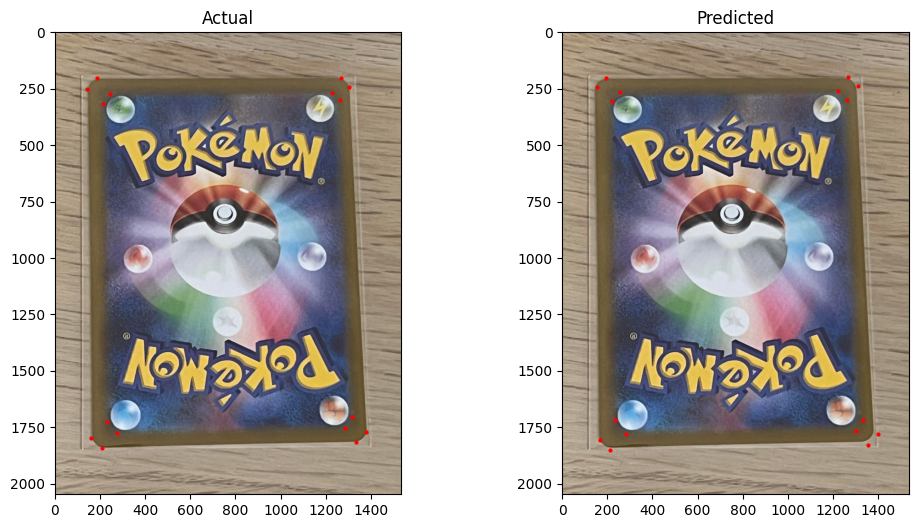

Loss:  1.3573784828186035


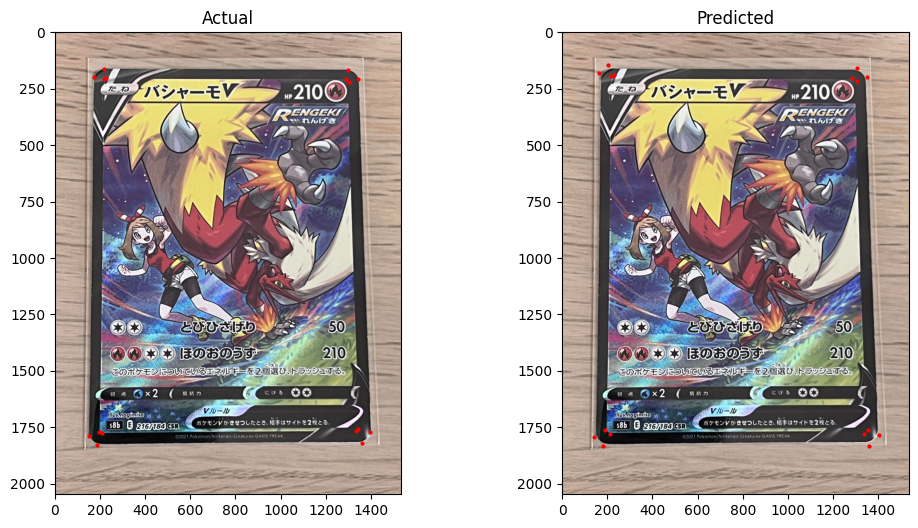

Loss:  1.5280436277389526


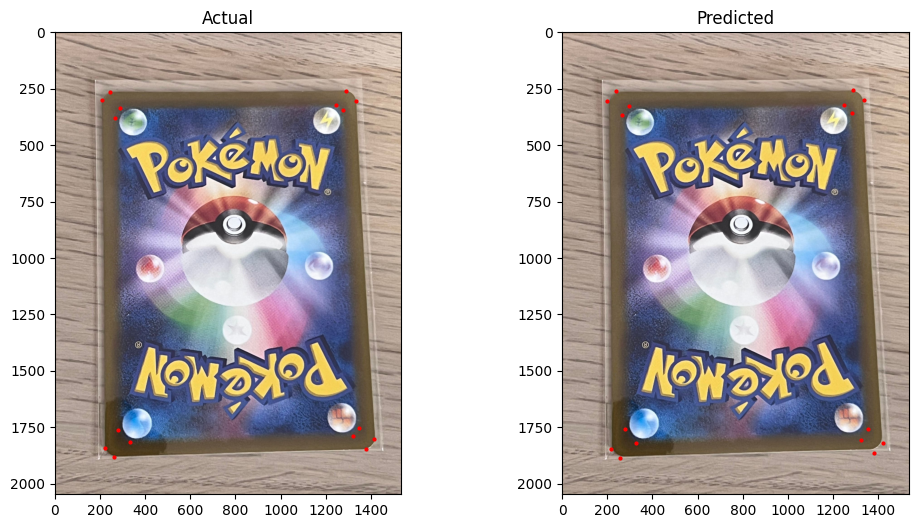

Loss:  1.4390478134155273


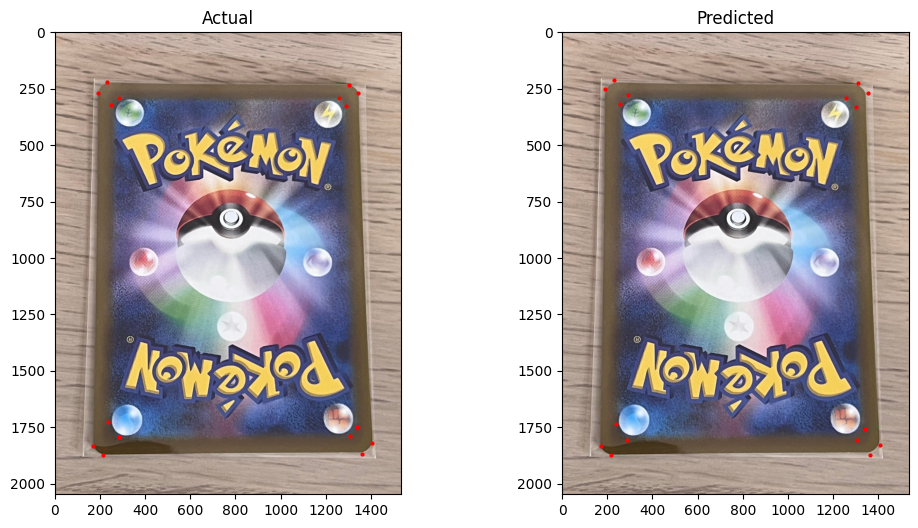

Loss:  0.5581191182136536


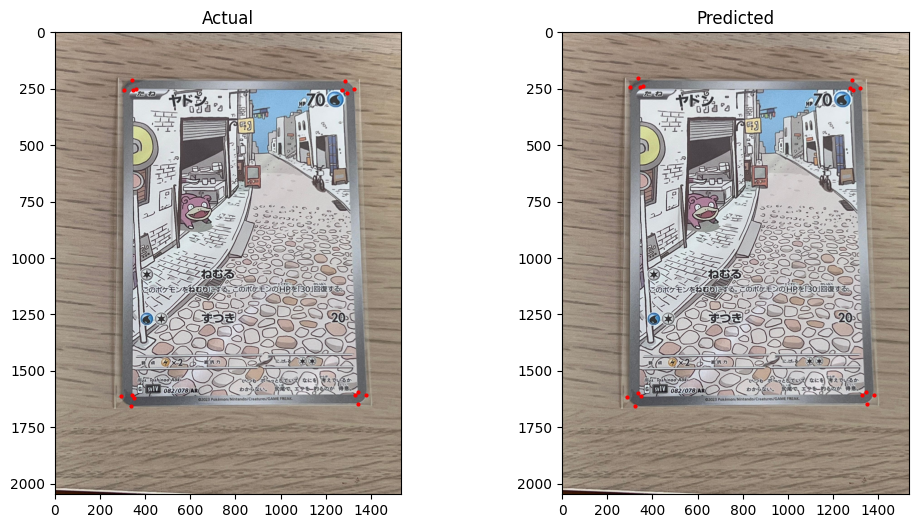

Loss:  1.0356333255767822


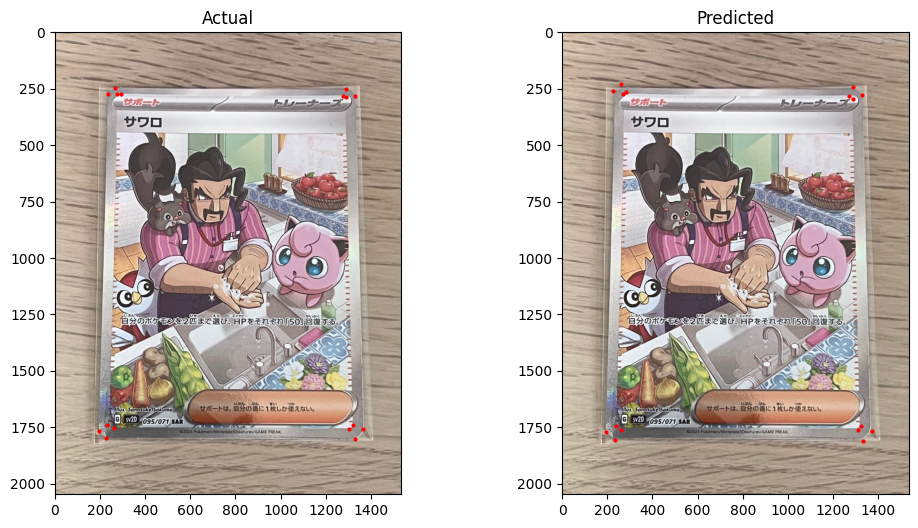

Loss:  0.9981232285499573


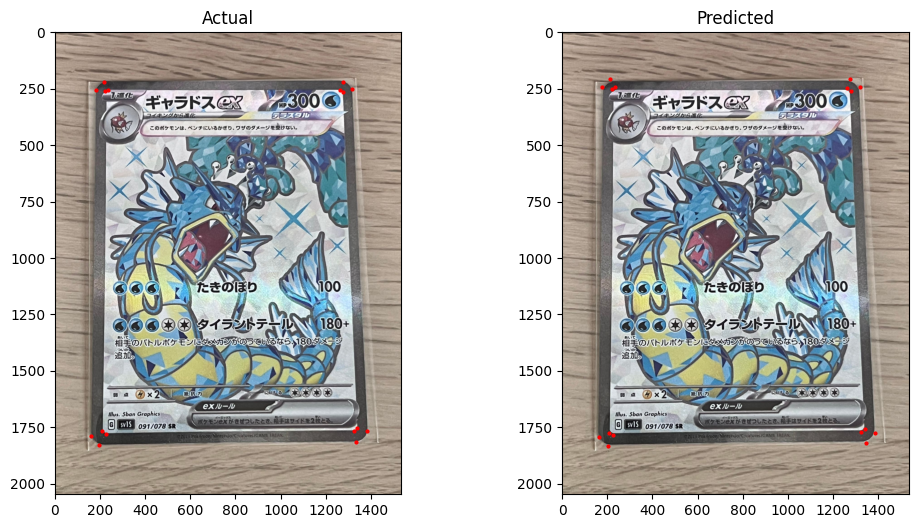

Loss:  1.1148260831832886


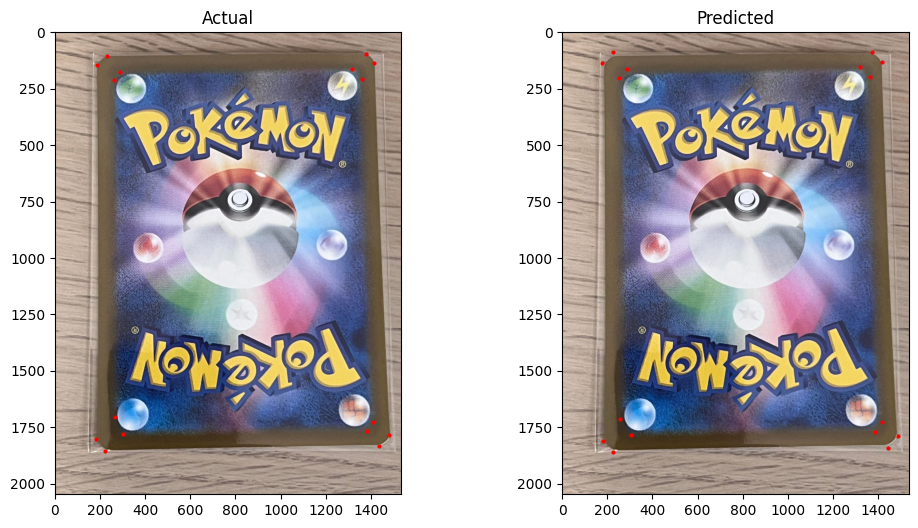

Loss:  1.0121515989303589


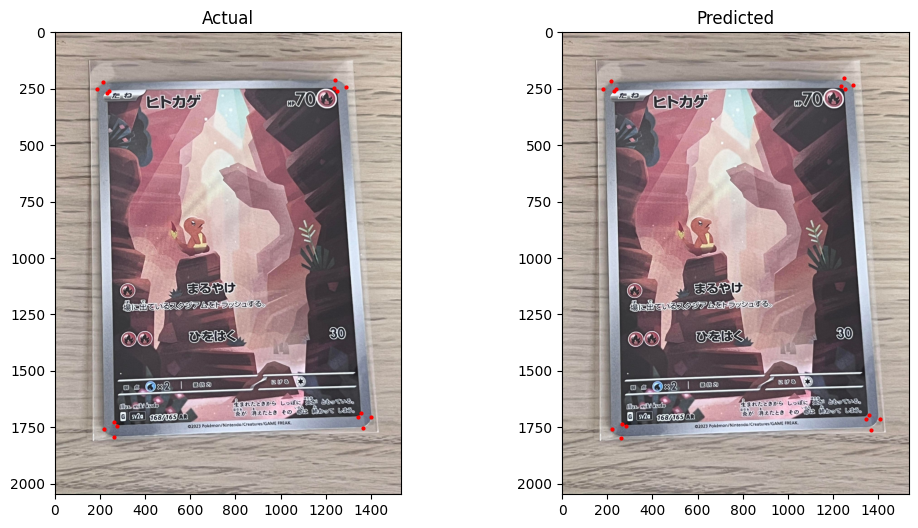

Loss:  1.07463800907135


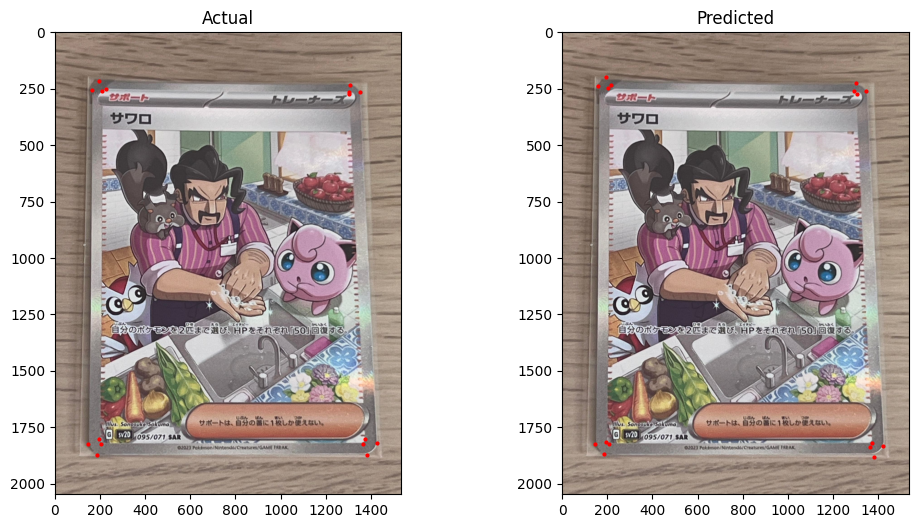

Loss:  2.555657386779785


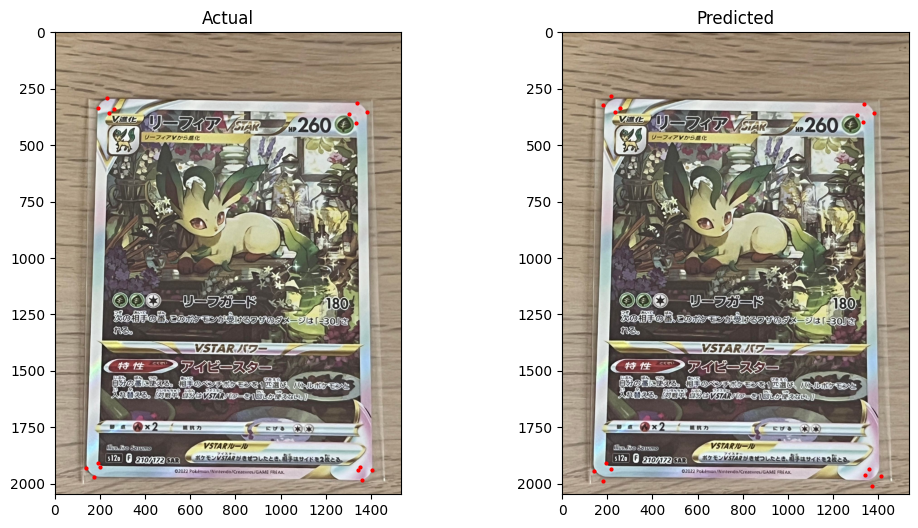

Loss:  1.568300724029541


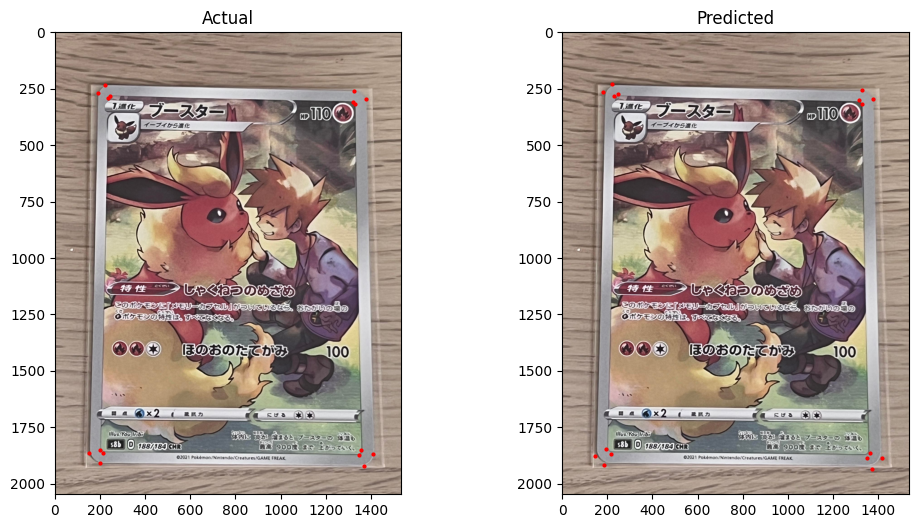

Loss:  1.2766401767730713


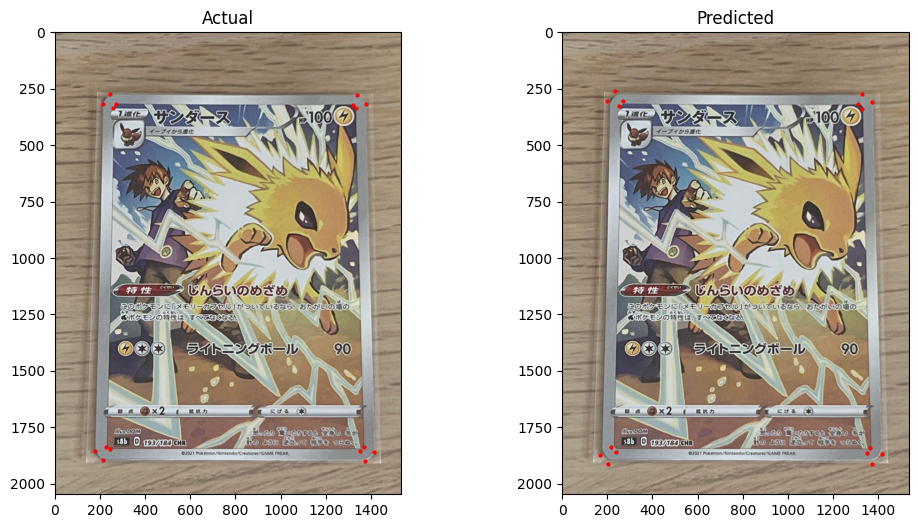

Loss:  1.7436691522598267


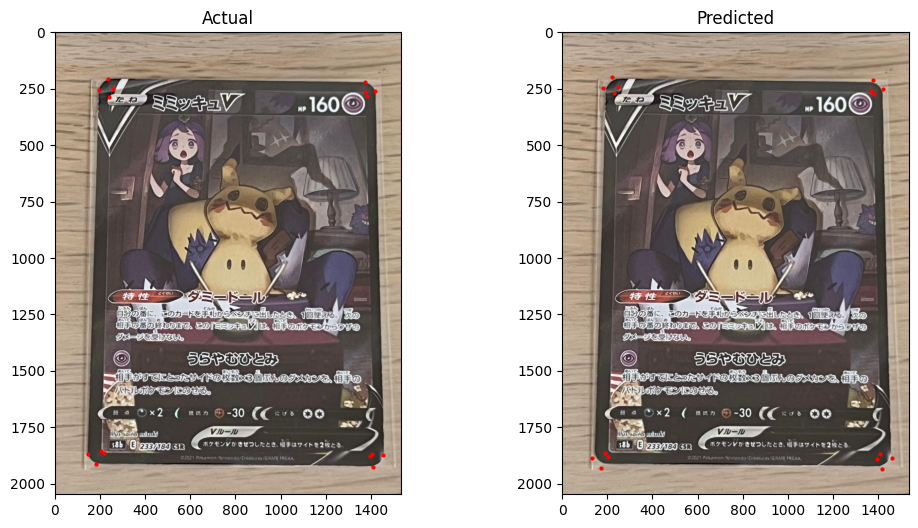

Loss:  1.952365517616272


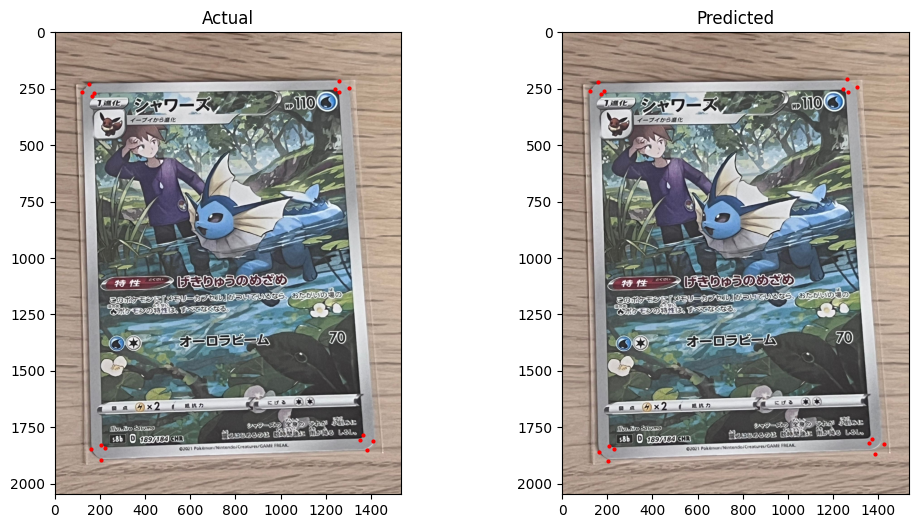

Loss:  0.7877559661865234


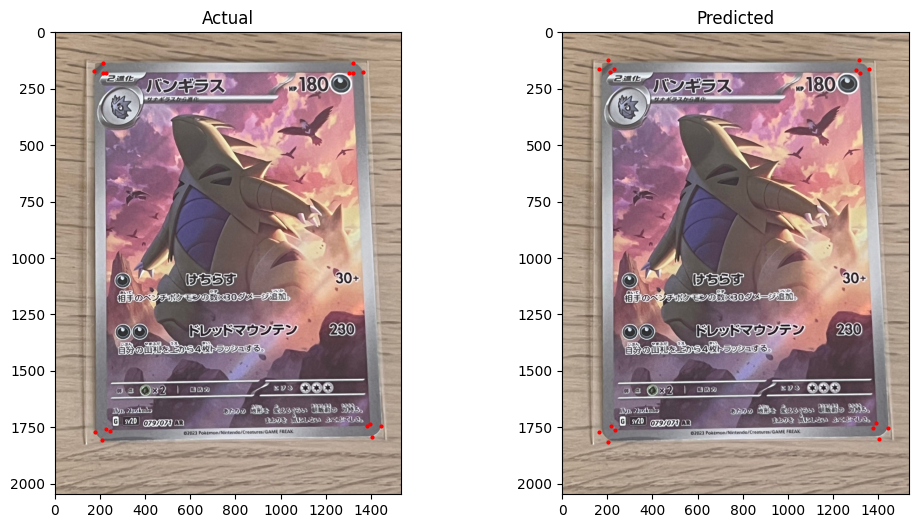

Loss:  1.1402809619903564


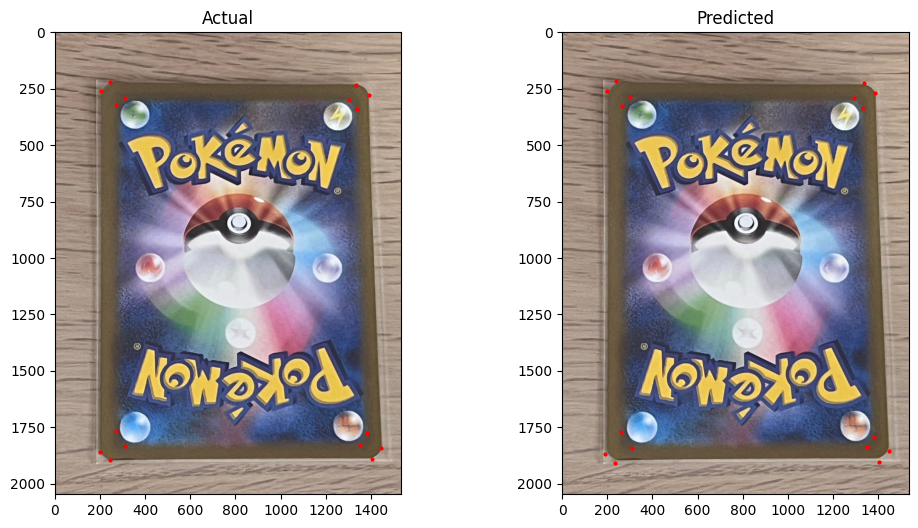

Loss:  1.408986210823059


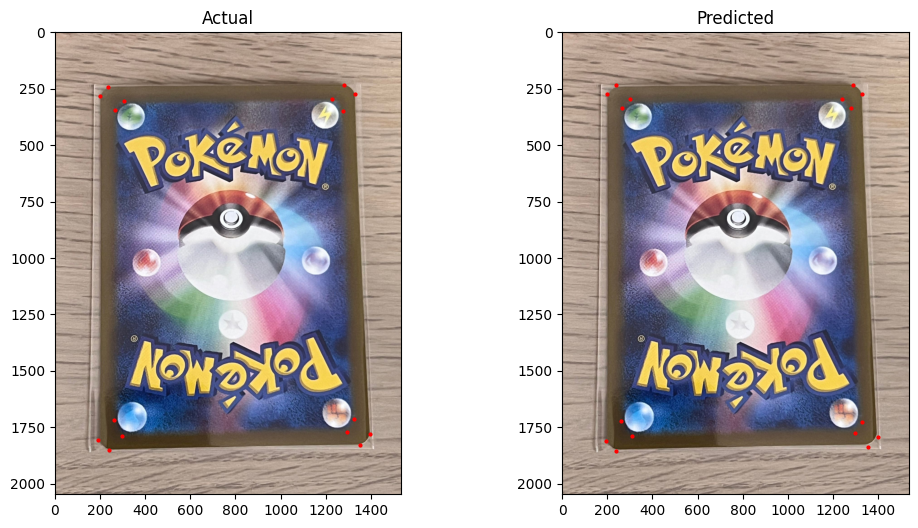

Loss:  2.627387046813965


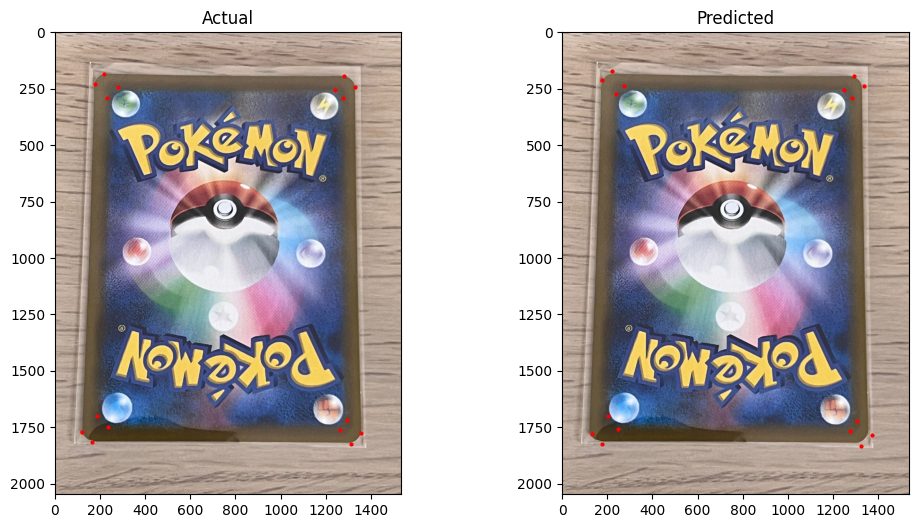

Loss:  1.602669358253479


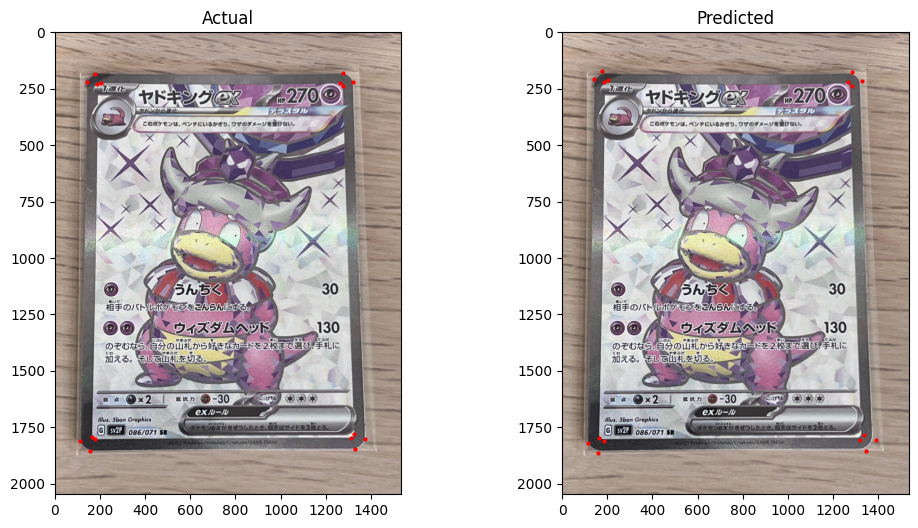

Loss:  1.081667184829712


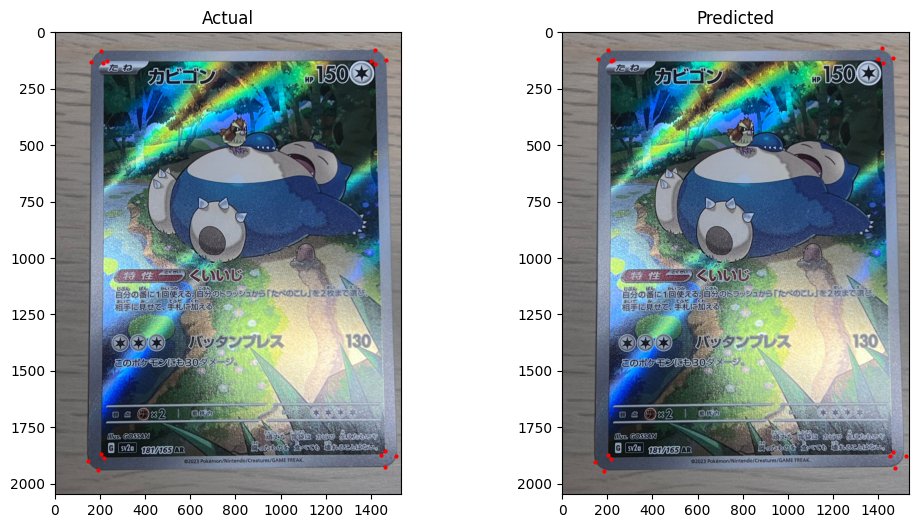

Loss:  0.8248401284217834


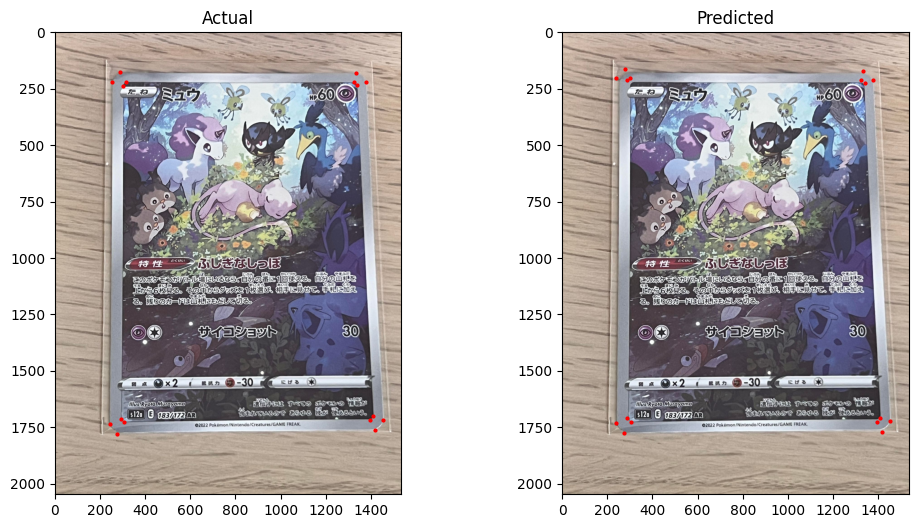

In [11]:
for i in data:
    i.predict_annotations(model)